In [24]:
import numpy as np
import matplotlib.pyplot as plt
import time

### OvR Kernel Perceptron

In [ ]:
class OvRKernelPerceptron:
    def __init__(self, k_classes):
        self.classifiers = None  # classifiers (the alphas)
        self.k_classes = k_classes
    
    def kernel_value(self, a, b):   # TODO: pass kernel as param
        # TODO: precompute kernel matrix for all data x_i x_j combos
        return np.dot(a, b) ** 3    # Polynomial kernel of degree 3
    
    def clear_classifiers(self, data):
        n_samples = len(data)
        self.classifiers = np.zeros((self.k_classes, n_samples))    # the alphas
    
    def class_prediction_kernel(self, data, pattern, classifier):
        prediction = 0.0
        for i in range(len(classifier)):    # TODO: online? t
            # Get the i-th training example's features
            x_i = data[i][1:257]
            prediction += classifier[i] * self.kernel_value(x_i, pattern)
        return prediction
    
    def train_classifiers(self, data):
        # Train all classifiers (for one epoch)
        mistakes = 0
        
        for i in range(len(data)):
            true_label = int(data[i][0])
            pattern = data[i][1:257]
            
            # Train each classifier
            max_pred = -1e18
            predicted_class = -1
            
            for j in range(self.k_classes):  
                y = 1.0 if (true_label == (j + 1)) else -1.0    # note: j=0 for digit1, etc.
                y_pred = self.class_prediction_kernel(data, pattern, self.classifiers[j])

                # Update if mistake
                if y * y_pred <= 0:     # equivalent to y != 'y_pred'
                    self.classifiers[j][i] += y   # update the alpha
                
                # Track predicted class for error counting
                if y_pred > max_pred:
                    max_pred = y_pred
                    predicted_class = j + 1
            
            # Count mistake if predicted wrong
            if predicted_class != true_label:
                mistakes += 1
        
        return mistakes
    
    def test_classifiers(self, train_data, test_data):
        mistakes = 0
        
        for i in range(len(test_data)):
            true_label = int(test_data[i][0])
            pattern = test_data[i][1:257]
            
            # Get predictions
            predictions = []
            for j in range(self.k_classes):
                pred = self.class_prediction_kernel(train_data, pattern, self.classifiers[j])
                predictions.append(pred)
            
            predictions = np.array(predictions)
            
            # Find class with maximum prediction for error counting
            predicted_class = np.argmax(predictions) + 1
            
            if predicted_class != true_label:
                mistakes += 1
        
        return mistakes
    
    def run(self, train_data, test_data, n_epochs):
        self.clear_classifiers(train_data)

        for epoch in range(n_epochs):

            # Training
            start_time = time.time()
            train_mistakes = self.train_classifiers(train_data)
            train_time = time.time() - start_time
            train_error = train_mistakes / len(train_data)
            print(f"Training - epoch {epoch+1} required {train_time:.2f}s "
                  f"with a training error of {train_error*100:.2f}%.")
            
            # Testing
            start_time = time.time()
            test_mistakes = self.test_classifiers(train_data, test_data)
            test_time = time.time() - start_time
            test_error = test_mistakes / len(test_data)
            print(f"Testing - epoch {epoch+1} required {test_time:.2f}s "
                  f"with a test error of {test_error*100:.2f}%.")



# TODO: Optimized version with vectorization for speed
class OptimizedKernelPerceptron(OvRKernelPerceptron):
    def __init__(self):
        super().__init__(3) # TODO: k_classes param, not 3
        self.kernel_matrix = None
    
    def precompute_kernel(self, data):
        """Precompute kernel matrix for faster training"""
        n_samples = len(data)
        # Extract features
        features = data[:, 1:257]
        
        # Compute kernel matrix K where K[i,j] = (x_i·x_j)^3
        self.kernel_matrix = np.zeros((n_samples, n_samples))
        
        # Compute dot products efficiently
        dot_matrix = np.dot(features, features.T)
        self.kernel_matrix = dot_matrix ** 3
    
    def clear_classifiers(self, data):
        """Initialize classifiers with precomputed kernel"""
        super().clear_classifiers(data)
        self.precompute_kernel(data)
    
    def class_prediction_kernel_optimized(self, pattern, classifier_idx, train_features):
        """Optimized prediction using precomputed kernel"""
        # Compute kernel values between pattern and all training samples
        kernel_vals = np.dot(train_features, pattern) ** 3
        return np.dot(self.classifiers[classifier_idx], kernel_vals)
    
    def train_generation_optimized(self, data):
        """Optimized training using precomputed kernel"""
        mistakes = 0
        features = data[:, 1:257]
        n_samples = len(data)
        
        for i in range(n_samples):
            true_label = int(data[i][0])
            pattern = features[i]
            
            # Get predictions using precomputed kernel
            kernel_vector = self.kernel_matrix[i, :]
            predictions = np.dot(self.classifiers, kernel_vector)
            
            # Train each classifier
            max_pred = -1e18
            predicted_class = -1
            
            for j in range(3):
                y = 1.0 if (true_label == (j + 1)) else -1.0
                
                # Update if mistake
                if y * predictions[j] <= 0:
                    self.classifiers[j][i] -= np.sign(predictions[j])
                
                # Track maximum prediction
                if predictions[j] > max_pred:
                    max_pred = predictions[j]
                    predicted_class = j + 1
            
            if predicted_class != true_label:
                mistakes += 1
        
        return mistakes
    
    def test_classifiers_optimized(self, train_data, test_data):
        """Optimized testing"""
        mistakes = 0
        train_features = train_data[:, 1:257]
        test_features = test_data[:, 1:257]
        
        # Precompute kernel between test and train
        kernel_test_train = np.dot(test_features, train_features.T) ** 3
        
        for i in range(len(test_data)):
            true_label = int(test_data[i][0])
            
            # Get predictions for this test sample
            predictions = np.dot(self.classifiers, kernel_test_train[i, :])
            
            # Find predicted class
            predicted_class = np.argmax(predictions) + 1
            
            if predicted_class != true_label:
                mistakes += 1
        
        return mistakes / len(test_data)


### Testing

In [26]:
def plot_digit(char_data, ax=None):
    # First element is label, next 256 are pixel values
    label = int(char_data[0])
    pixels = char_data[1:257].reshape(16, 16)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    ax.imshow(pixels, cmap='gray')
    ax.set_title(f'The number {label}')
    ax.axis('off')
    return ax

#### Demo Run with 123 datasets

Training data shape: (329, 257)
Test data shape: (456, 257)


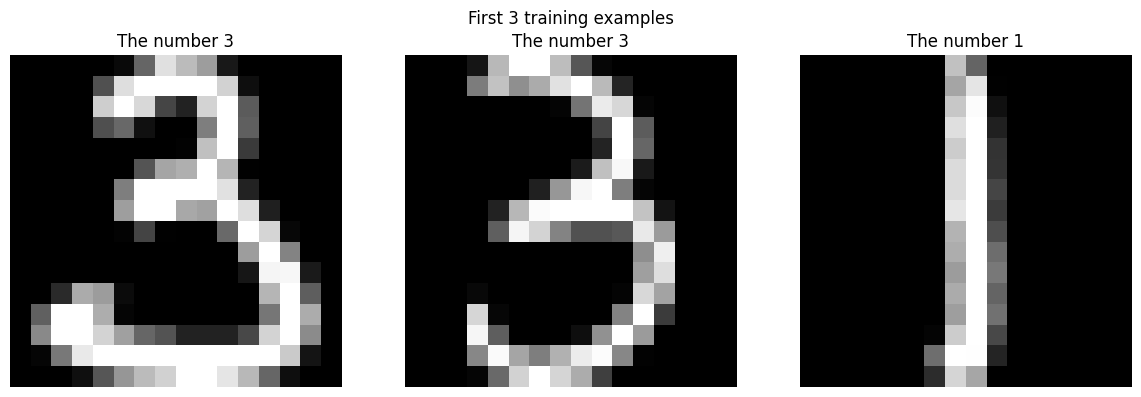


Running Kernel Perceptron Demo...
Training - epoch 1 required 1.12s with a training error of 4.56%.
Testing - epoch 1 required 1.56s with a test error of 4.39%.
Training - epoch 2 required 1.13s with a training error of 0.61%.
Testing - epoch 2 required 1.56s with a test error of 2.63%.


In [27]:
kp = OvRKernelPerceptron(3)
dtrain123 = np.loadtxt('dtrain123.dat')
dtest123 = np.loadtxt('dtest123.dat')
print(f"Training data shape: {dtrain123.shape}")
print(f"Test data shape: {dtest123.shape}")

# Plot first few digits
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    plot_digit(dtrain123[i], axes[i])
plt.suptitle("First 3 training examples")
plt.tight_layout()
plt.show()

# Run demo
print("\nRunning Kernel Perceptron Demo...")
kp.run(dtrain123, dtest123, 2)